# Project Info #

- Developed by: Sean Pritchard
- for: CSCA 5622-100: Introduction to Machine Learning: Supervised Learning final project
- URL: https://github.com/seanpritchard94/gone_phishing
- Data Source: https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data (Ovi, 2025)
- Python version: 3.13


# Supervised Learning Problem Description #


Phishing is a technique where criminals attempt to trick victims into providing personal information, payment information, login credentials and/or other sensitive information which the criminals then use to commit theft and fraud. Phishing often uses email or text messages that direct victims to look-alike sites masquerading as a valid financial institution, merchant, or govenrment agency. These look-alike sites are where the criminals collect sensitive information from victims.

The FBI's *Internet Crime Report 2024* lists phishing/spoofing as the most common internet crime with almost 200,000 complaints. more than double the next most common internet crime of extortion. Losses attributed to phishing/spoofing exceeded $70 million in 2024 alone. (Yarbrough, n.d.).

Automatic detection of such sites is an important part of protecting potential victims from phishing. This project uses data provided by Kaggle (Ovi, 2025) containing features from both phishing and non-phishing sites. This project explores the effectiveness of various machine learning algorithms in predicting phishing sites based on these features.

**Type of Learning and Task:** This is a **binary classification** machine learning problem. I will evaluate **multiple classification algorithms** including Logistic Regression, K Nearest Neighbors, Decision Tree, Adaptive Boosting, Gradient Boosting, Random Forest, Support Vector Machines, Naive Bayes, Multi-layer Perceptron, and Voting Classifier algorithms to determine which performs best with this dataset.

**Project Goal:** Determine the effectiveness of various machine learning algorithms and identify the best machine learning algorithm for detecting phishing sites based on the selected data set.


# Data #

The source of the data for this project is dataset 6 from *Phishing Website Detection Datasets* available on Kaggle at https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data (Ovi, 2025).

The data is **tabular** with **10,000 samples.** The samples are evenly balanced between positive and negative classes. The dataset contains **50 columns.** The columns include an ID, the class label and **48 features.** The features include numeric features, categorical, and binary features. Examples of each type are as follows:

| Feature name     | type        | description                                      |
|------------------|-------------|--------------------------------------------------|
| NumDots          | numerical   | The number of dots in the URL                    |
| UrlLength        | numerical   | The number of characters in the URL              |
| HostnameLength   | numerical   | The number of characters in the hostname         |
| RandomString     | binary      | true if the URL contains a random string         |
| DomainInPaths    | binary      | true if the path contains a domain name          |
| UrlLengthRT      | categorical | -1,0,1 based on a rule about the UrlLength       |
| SubdomainLevelRT | categorical | -1,0,1 based on a rule about the Subdomain level |



In [44]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
#first we will take a quick look at the data
df = pd.read_csv('data/dataset6.csv')
df.head(10)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
5,6,3,1,1,42,1,0,0,0,0,...,1,1,0,1,1,1,1,-1,1,1
6,7,2,0,5,60,0,0,0,0,0,...,0,0,0,1,0,1,1,-1,-1,1
7,8,1,0,3,30,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
8,9,8,7,2,76,1,1,0,0,0,...,0,0,0,-1,-1,1,1,1,-1,1
9,10,2,0,2,46,0,0,0,0,0,...,0,0,0,1,1,1,1,-1,-1,1


**A complete list of the features and their datatype is provided below**

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

# Data Cleaning #

Before I attempt data cleaning, I need to better understand the data. A histogram plot for all features will help with this.


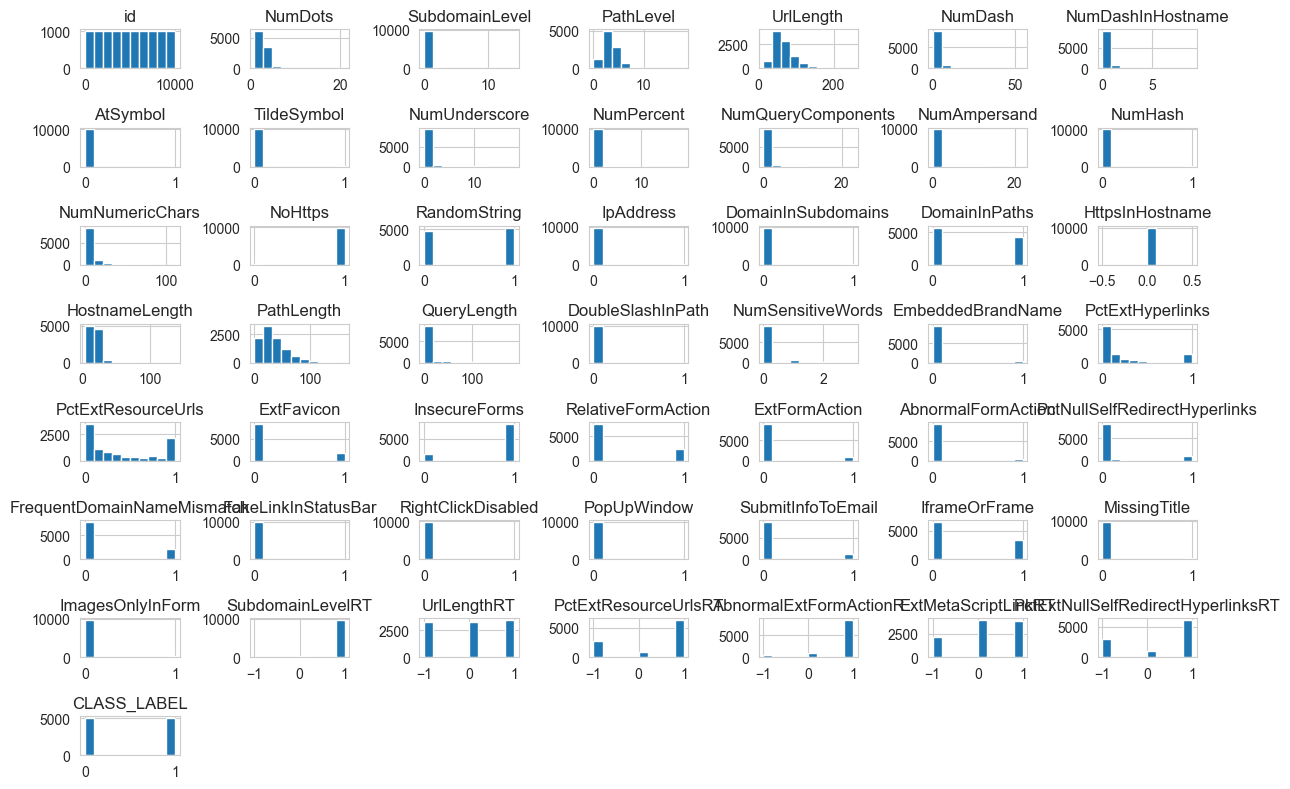

In [15]:
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

This is a fairly clean data set with no NaN values found. However, data cleaning is still required because several of the features seem to be based on a **rule transformation of another feature**. The rules used for the transformation are **not documented.** It appears that these features are taking continuous values such as SubdomainLevel and UrlLength and converting them to a categorical value of -1, 0, 1. The meaning of these categorical values is not documented. It may be that the values mean something like "dangerous, unknown, and safe." If it is true that the values have such meaning, then these fields could be considered to be an **"answer key" generated by undocumented rules in an external system.** Additionally, it is unclear how the thresholds were arrived at. Even if these fields do have the meaning I assume, and they are correct, this **potentially undermines my project** by training my models to detect patterns in the "answer key" rather than in the raw data. **For these reasons, I will drop the following columns:**

- SubdomainLevelRT
- UrlLengthRT
- PctExtResourceUrlsRT
- AbnormalExtFormActionR
- ExtMetaScriptLinkRT
- PctExtNullSelfRedirectHyperlinksRT

In [17]:
df.drop(inplace=True, columns = ['id', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NumDots                        10000 non-null  int64  
 1   SubdomainLevel                 10000 non-null  int64  
 2   PathLevel                      10000 non-null  int64  
 3   UrlLength                      10000 non-null  int64  
 4   NumDash                        10000 non-null  int64  
 5   NumDashInHostname              10000 non-null  int64  
 6   AtSymbol                       10000 non-null  int64  
 7   TildeSymbol                    10000 non-null  int64  
 8   NumUnderscore                  10000 non-null  int64  
 9   NumPercent                     10000 non-null  int64  
 10  NumQueryComponents             10000 non-null  int64  
 11  NumAmpersand                   10000 non-null  int64  
 12  NumHash                        10000 non-null  

# EDA Procedure #

From the histograms in data cleaning, we can see that the scale of the various data fields is significantly different with some fields varying from 1-10 or 1-20 and others running into the hundreds. Also, the values tend to be skewed towards the low end rather than balanced around the mean. Some ML models don't do well with these kinds of data, so we will use scikit learn's StandardScaler to move all fields to a common scale



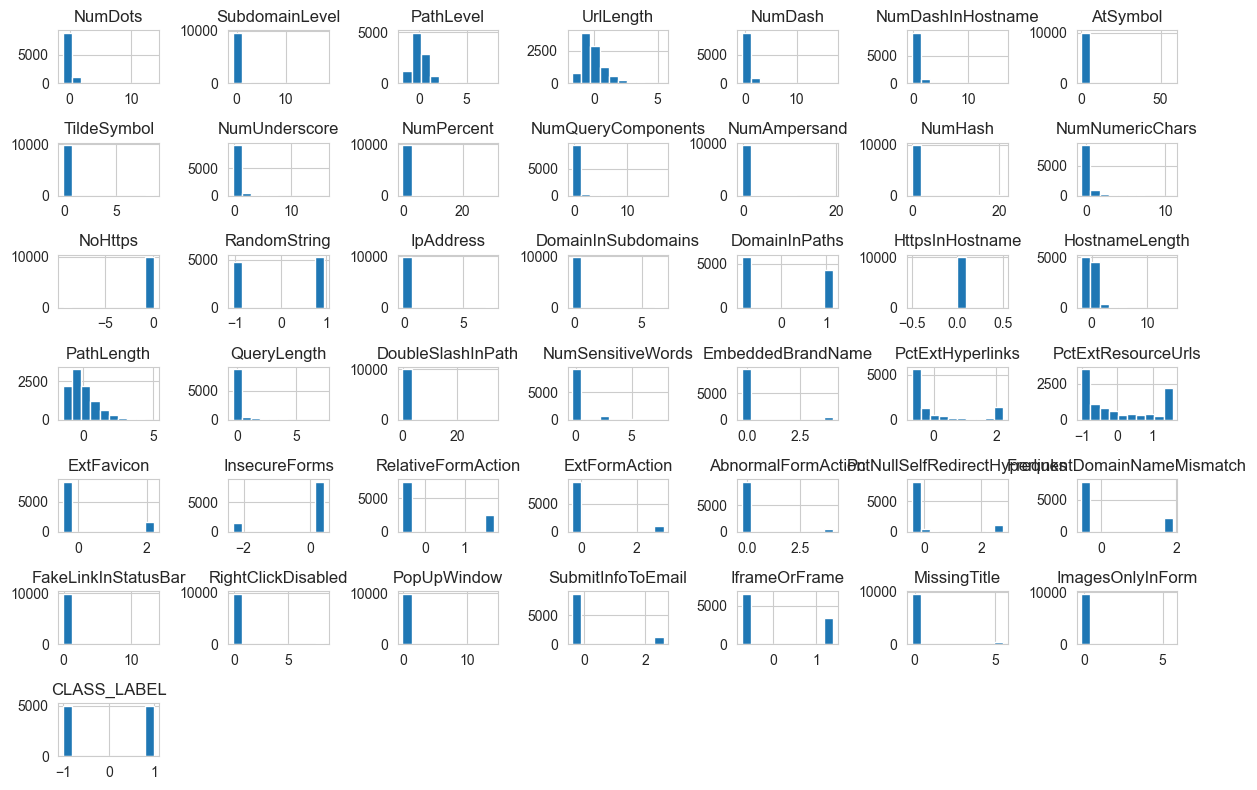

In [18]:
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled.hist(figsize=(12,8))
plt.tight_layout()
plt.show()



Some models perform poorly when there is high correlation between the features.

In [19]:
correlation = df.corr()
correlation

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,CLASS_LABEL
NumDots,1.000000,0.507992,0.079202,0.277380,-0.198769,0.093034,0.011425,0.109508,0.038068,0.022616,...,0.033516,0.177703,-0.002490,0.050992,-0.031698,-0.117766,-0.117210,0.045291,-0.012244,0.294111
SubdomainLevel,0.507992,1.000000,0.007277,0.098579,-0.050018,0.246368,-0.005845,0.009518,-0.023593,-0.006003,...,0.106631,-0.061013,-0.023893,0.133530,-0.010968,-0.027739,-0.001061,0.026432,-0.008830,0.043132
PathLevel,0.079202,0.007277,1.000000,0.390456,0.090503,0.027626,-0.005891,0.127291,0.015719,-0.043529,...,0.085679,0.028918,-0.004003,0.049318,0.014823,-0.061813,0.000701,-0.027880,-0.002279,0.229450
UrlLength,0.277380,0.098579,0.390456,1.000000,0.437313,0.111980,-0.003425,0.058233,0.350756,0.184947,...,-0.090563,-0.099667,0.014242,0.087848,0.034980,0.042056,0.033192,-0.053222,-0.036766,-0.074493
NumDash,-0.198769,-0.050018,0.090503,0.437313,1.000000,0.113200,-0.010139,-0.024395,-0.050195,-0.017938,...,-0.113173,-0.188701,-0.007831,0.063704,0.092634,0.181687,0.228154,-0.064450,-0.006314,-0.372235
NumDashInHostname,0.093034,0.246368,0.027626,0.111980,0.113200,1.000000,-0.004409,-0.018043,-0.035170,-0.021648,...,0.177997,-0.019193,-0.009018,0.439129,-0.015237,-0.059574,0.040743,-0.010096,-0.007712,0.150444
AtSymbol,0.011425,-0.005845,-0.005891,-0.003425,-0.010139,-0.004409,1.000000,-0.001996,-0.005023,0.007226,...,-0.005682,-0.009074,-0.001288,-0.002064,-0.001216,-0.006661,-0.012422,-0.003160,-0.003067,-0.017323
TildeSymbol,0.109508,0.009518,0.127291,0.058233,-0.024395,-0.018043,-0.001996,1.000000,-0.022361,-0.013665,...,0.002866,0.038078,-0.008568,0.001243,-0.008085,-0.039048,-0.039905,-0.011051,-0.020400,0.095864
NumUnderscore,0.038068,-0.023593,0.015719,0.350756,-0.050195,-0.035170,-0.005023,-0.022361,1.000000,0.061638,...,-0.095099,-0.037074,0.018468,-0.023862,0.002779,0.037957,-0.010341,-0.019348,-0.019467,-0.098869
NumPercent,0.022616,-0.006003,-0.043529,0.184947,-0.017938,-0.021648,0.007226,-0.013665,0.061638,1.000000,...,-0.023362,-0.030065,-0.006647,-0.014133,-0.003720,0.000454,-0.021592,-0.011620,-0.006960,-0.068465


<Axes: >

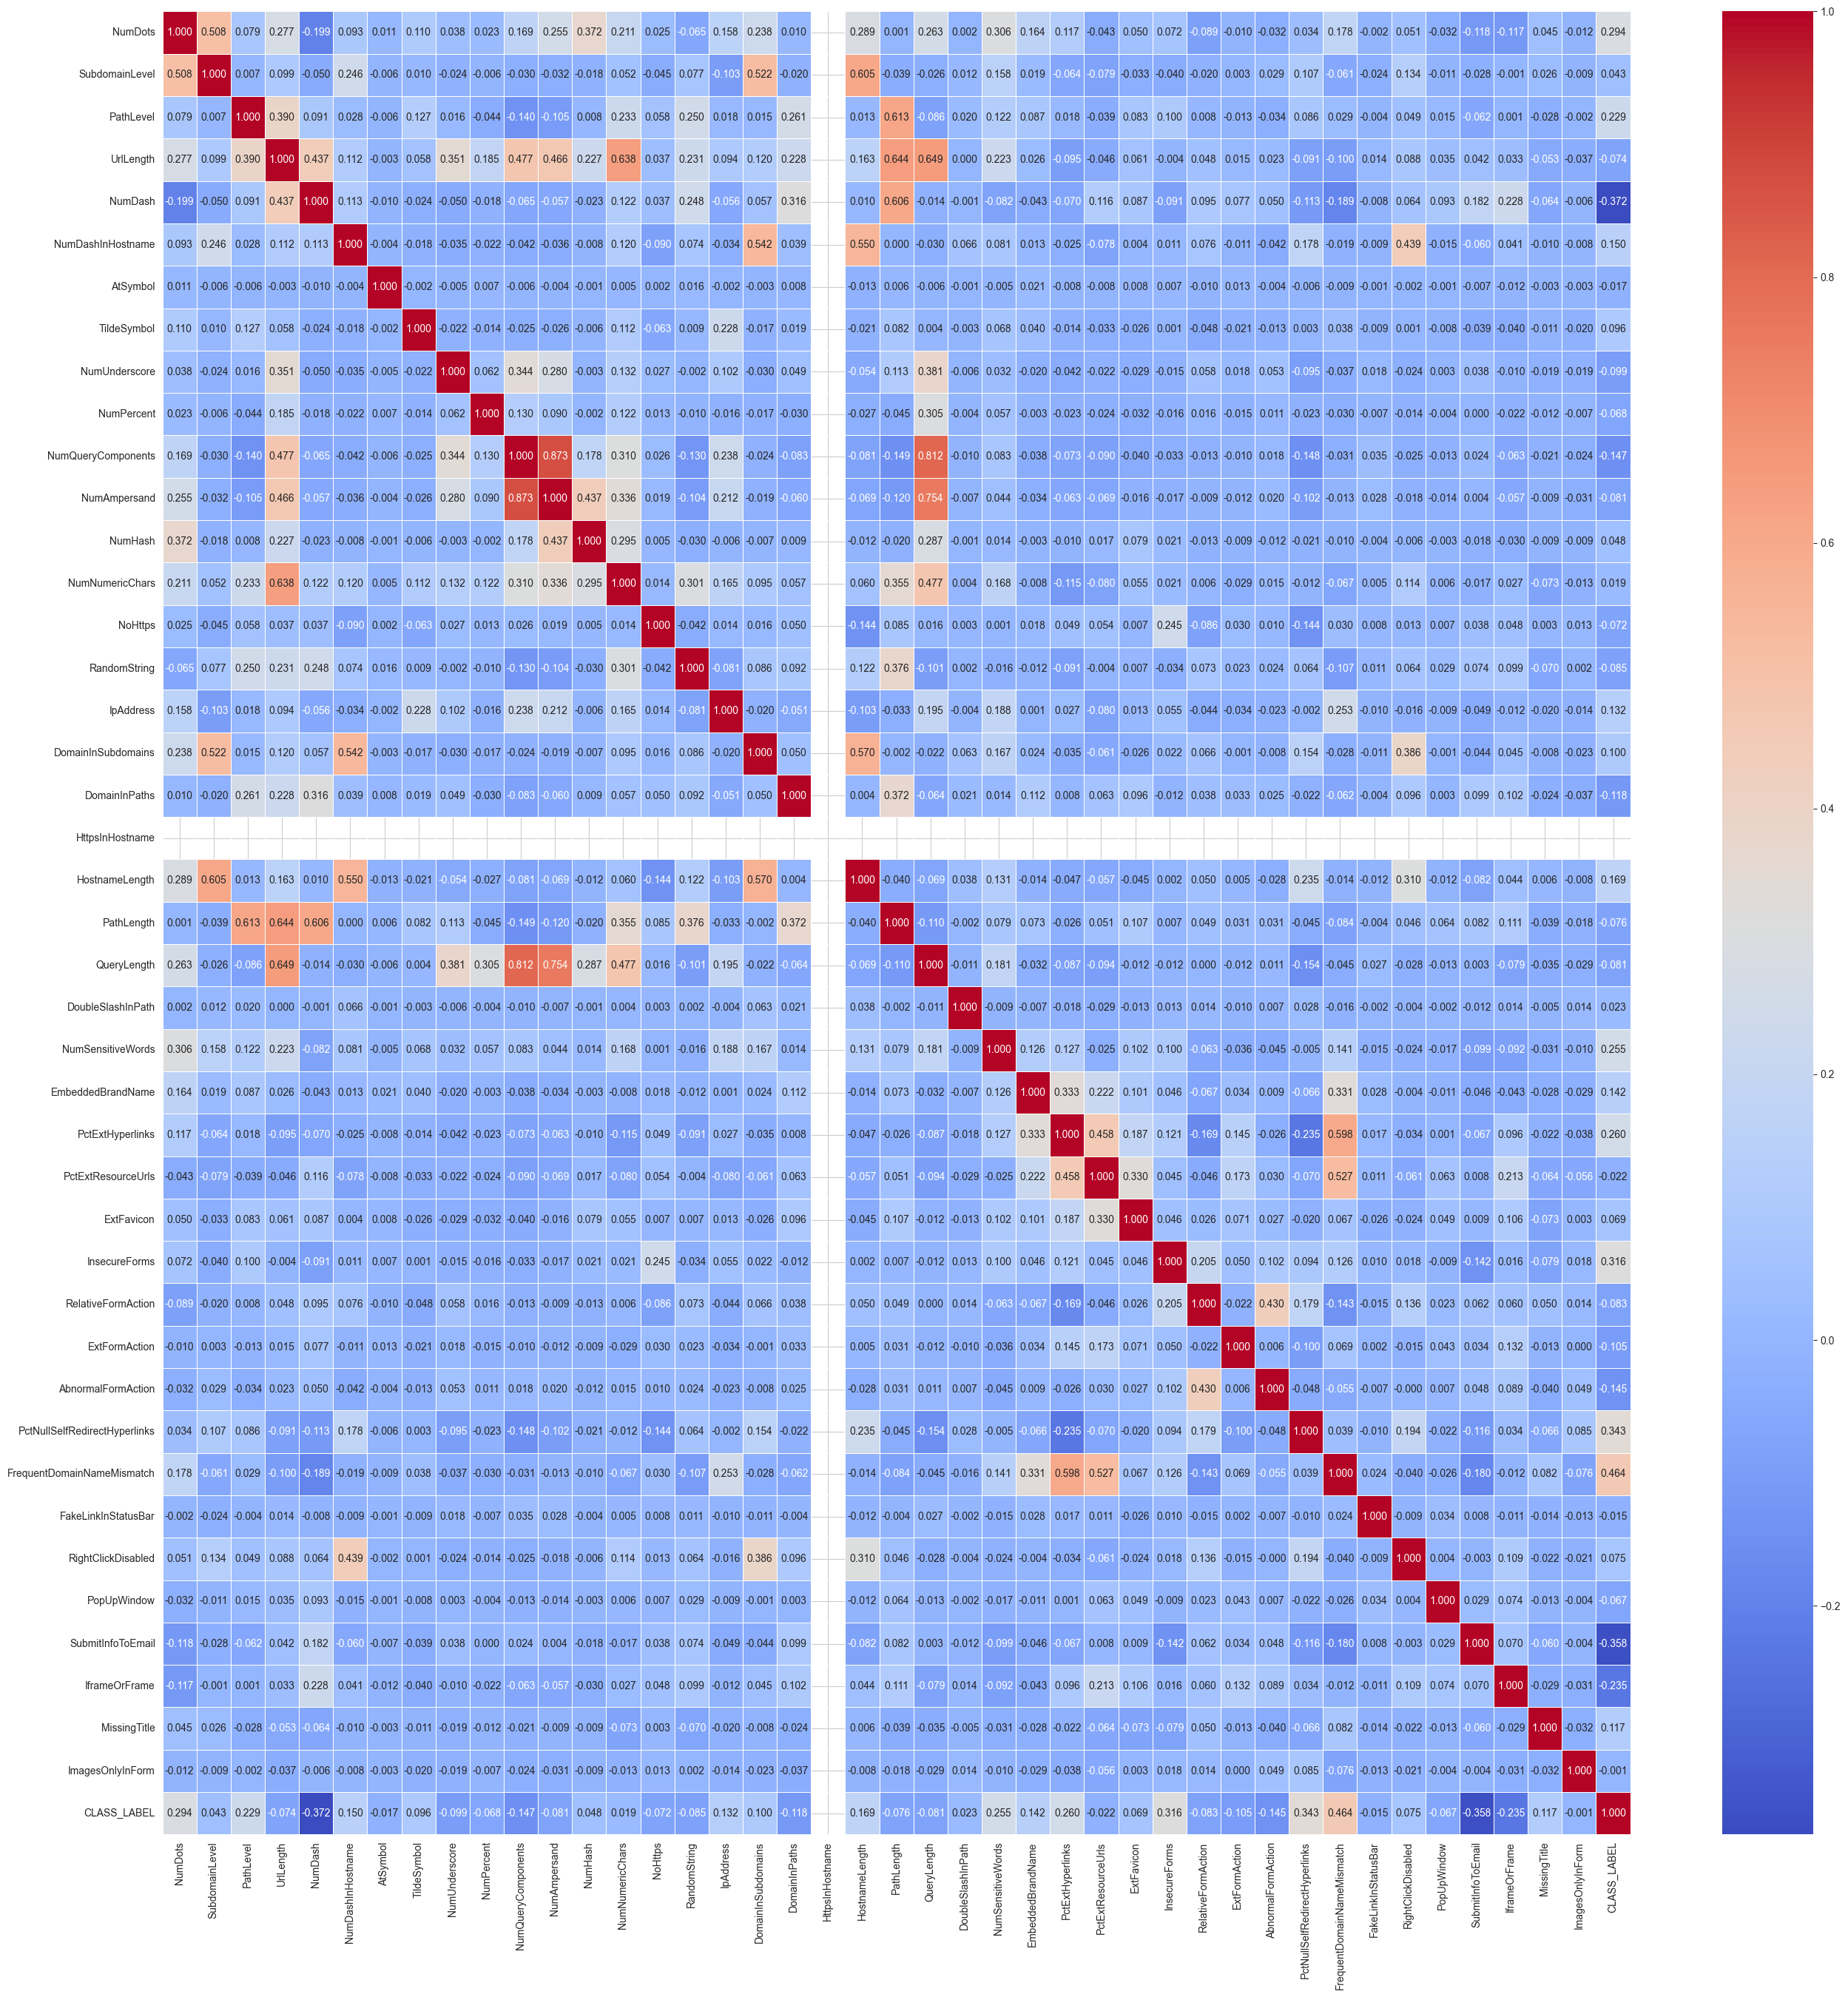

In [20]:
plt.subplots(figsize=(32, 32))
sns.heatmap(correlation, annot=True, fmt=".3f", linewidth=.5, cmap="coolwarm")

### Multicollinearity ####

A few of the features are highly correlated. Some models such as LogisticRegression and NaiveBayes do poorly with highly correlated features. QueryLength, NumQueryComponents, and NumAmpersand are highly correlated. This makes intuitive sense given that ampersands are used to separate query components. A large number of query components would naturally mean a large number of ampersands and a longer query length. Of the three, NumQueryComponents is most strongly correlated with the label, so I will drop QueryLength and NumAmpersand which are providing essentially the same information.





In [21]:
df.drop(inplace=True, columns = ['QueryLength', 'NumAmpersand'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NumDots                        10000 non-null  int64  
 1   SubdomainLevel                 10000 non-null  int64  
 2   PathLevel                      10000 non-null  int64  
 3   UrlLength                      10000 non-null  int64  
 4   NumDash                        10000 non-null  int64  
 5   NumDashInHostname              10000 non-null  int64  
 6   AtSymbol                       10000 non-null  int64  
 7   TildeSymbol                    10000 non-null  int64  
 8   NumUnderscore                  10000 non-null  int64  
 9   NumPercent                     10000 non-null  int64  
 10  NumQueryComponents             10000 non-null  int64  
 11  NumHash                        10000 non-null  int64  
 12  NumNumericChars                10000 non-null  

### Correlation Matrix Analysis ###

It is interesting to note that no features are stongly correlated to the label.  There are several features that more correlated than others with the CLASS_LABEL. These include FrequentDomainNameMismatch (0.464), InsecureForms (0.31), NumDots (0.294), NumDash (-0.372), and SubmitInfoToEmail (-0.358). But the vast majority of features have almost no correlation with the class label.

### Selecting Train and Test Data ###

Next the data must be shuffled and split into a test abnd training set.

In [22]:
shuffled_df = shuffle(df_scaled, random_state=42)
feature_names = shuffled_df.columns.tolist()
y = shuffled_df['CLASS_LABEL'].values
y = np.array(pd.to_numeric(y))
X = shuffled_df.drop('CLASS_LABEL', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### EDA Discussions and Conclusion ###

The initial data was not well suited for a machine learning project. It included categorical columns generated by external, undocumented systems. It included several highly correlated features related to the HTTP query component. And the features used inconsistent ranges of data and were not centered around a mean of zero.

The following steps were taken to prepare the data for the project
- removing data which was generated by undocumented external rules (all of the RT columns)
- removing highly correlated columns related to the query
- standardizing and scaling the features
- shuffled and split into a train and test data set

The data is now well-suited for a machine learning project.

# Analysis (Model Building and Training) #

In the following section, I will evaluate **multiple ML models** including Logistic Regression, K Nearest Neighbors, Decision Tree, Adaptive Boosting, Gradient Boosting, Random Forest, Support Vector Machines, Naive Bayes, Multi-layer Perceptron, and Voting Classifier algorithms to determine which performs best with this dataset. I will use **hyperparamter tuning** to optimize each model using a GridSearch. I will use **Cross Fold Validation** to minimize overfitting. All results will be based on test data that the model did not see during training. Several **models not covered in class** will be used.

## Logistic Regression ##



In [23]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.92      0.93      0.93       987
         1.0       0.94      0.92      0.93      1013

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



An f1 of 93% for both classes is not bad at all. But lets try a little bit of hyperparameter tuning along with Cross Fold Validation at the same time to see if we can do a little better. Suggestions for what hyperparameters to tune and what values to try came from a Geeks for Geeks article (GeeksforGeeks, 2025b)

{'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

        -1.0       0.92      0.93      0.93       987
         1.0       0.94      0.92      0.93      1013

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
120 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sean.pritchard/git/gone_phishing/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sean.p

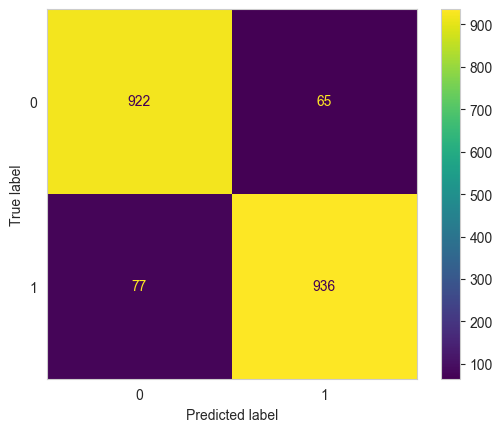

In [25]:
lr_params = [{'penalty':['l1','l2','elasticnet'],
           'solver': ['lbfgs','liblinear','newton-cg','sag','saga'],
           'max_iter'  : [2500,5000,10000]}]
gs_lr_clf = GridSearchCV(LogisticRegression(), param_grid=lr_params, scoring='f1', cv=5)
gs_lr_clf.fit(X_train, y_train)
print(gs_lr_clf.best_params_)
y_hat = gs_lr_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We were not able to improve the f1 score even though a different solver was selected as best by the gridsearch. The warnings indicate that for some combinations, no solution was found. This is expected. The sklearn docs warn that not all of the penalties work with all of the solvers.

## K Nearest Neighbors ##


In [26]:
#first lest's try a naive knn classifier and see how it performs
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
print(classification_report(y_test, knn_clf.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.94      0.94      0.94       987
         1.0       0.94      0.94      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



An f1 of 94% for both classes is not bad at all. But lets try a little bit of hyperparameter tuning along with Cross Fold Validation at the same time to see if we can do a little better. Suggestions for which hyperparameters to tune and values to try came from a Medium article (Kumar, 2024)

{'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

        -1.0       0.95      0.94      0.94       987
         1.0       0.94      0.95      0.94      1013

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



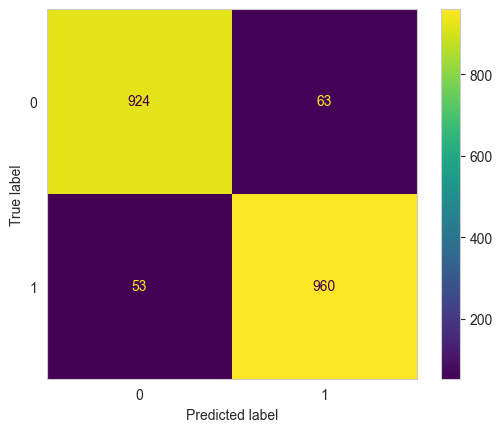

In [27]:
knn_params = [{'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
           'weights': ['uniform', 'distance'],
           'leaf_size': [10, 20, 30, 40, 50]}]
gs_knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, scoring='f1', cv=5)
gs_knn_clf.fit(X_train, y_train)
print(gs_knn_clf.best_params_)
y_hat = gs_knn_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Unfortunately, the grid search did not provide any improvement. My naive KNN classifier had already been quite close to the optimal hyperparameters. But still 0.94 for F1 is not bad.

## Decision Tree ##


In [28]:
#first lest's try a naive decision tree classifier and see how it performs
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print(classification_report(y_test, dt_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96       987
         1.0       0.96      0.96      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



The F1 of 96% for a naive decision tree is almost spectacular. We will try a GridSearch for improvement through hyperparameter tuning...

{'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 3}
              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96       987
         1.0       0.96      0.96      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



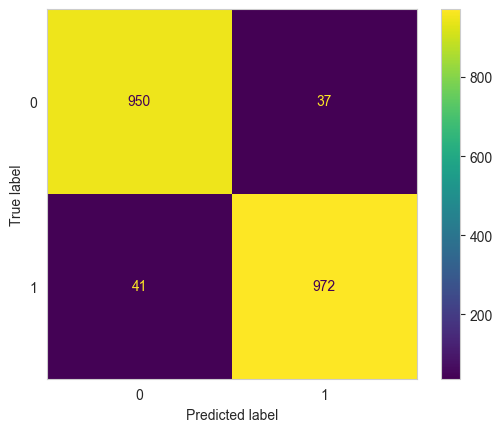

In [29]:
dt_params = [{'max_depth': [5, 10, 15, 20, 25],
           'criterion': ["gini", "entropy", "log_loss"],
           'min_samples_leaf': [1, 2, 3, 4, 5]}]
gs_dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_params, scoring='f1', cv=5)
gs_dt_clf.fit(X_train, y_train)
print(gs_dt_clf.best_params_)
y_hat = gs_dt_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

It turns out once again that a grid search did not really move the needle. Though log_loss was selected as the best criterion, it did not perform noticeably better than the default of gini. I am curious to see what the decision tree looks like, so I will plot it below. The nice thing about Decision Trees is that they are so explainable.

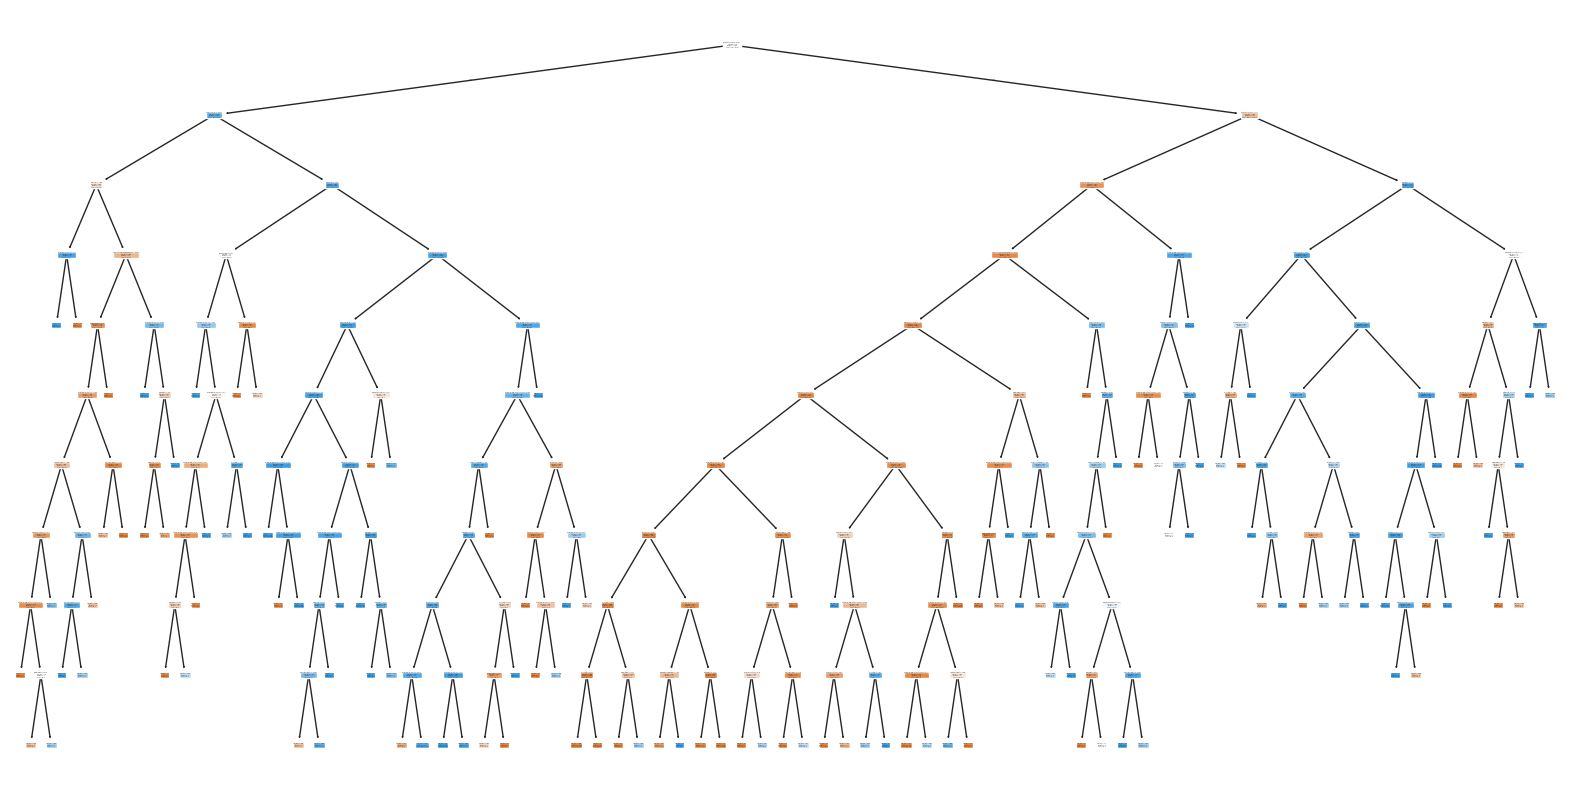

In [30]:
plt.figure(figsize=(20, 10))
plot_tree(gs_dt_clf.best_estimator_, feature_names=feature_names, filled=True)
plt.show()

The entire tree is too large to plot in a readable manner, so here is a tree with the first four levels. It is interesting to see that many of the fileds more strongly correlated with CLASS_LABEL appeared near the top of the tree. This intuitively makes sense.

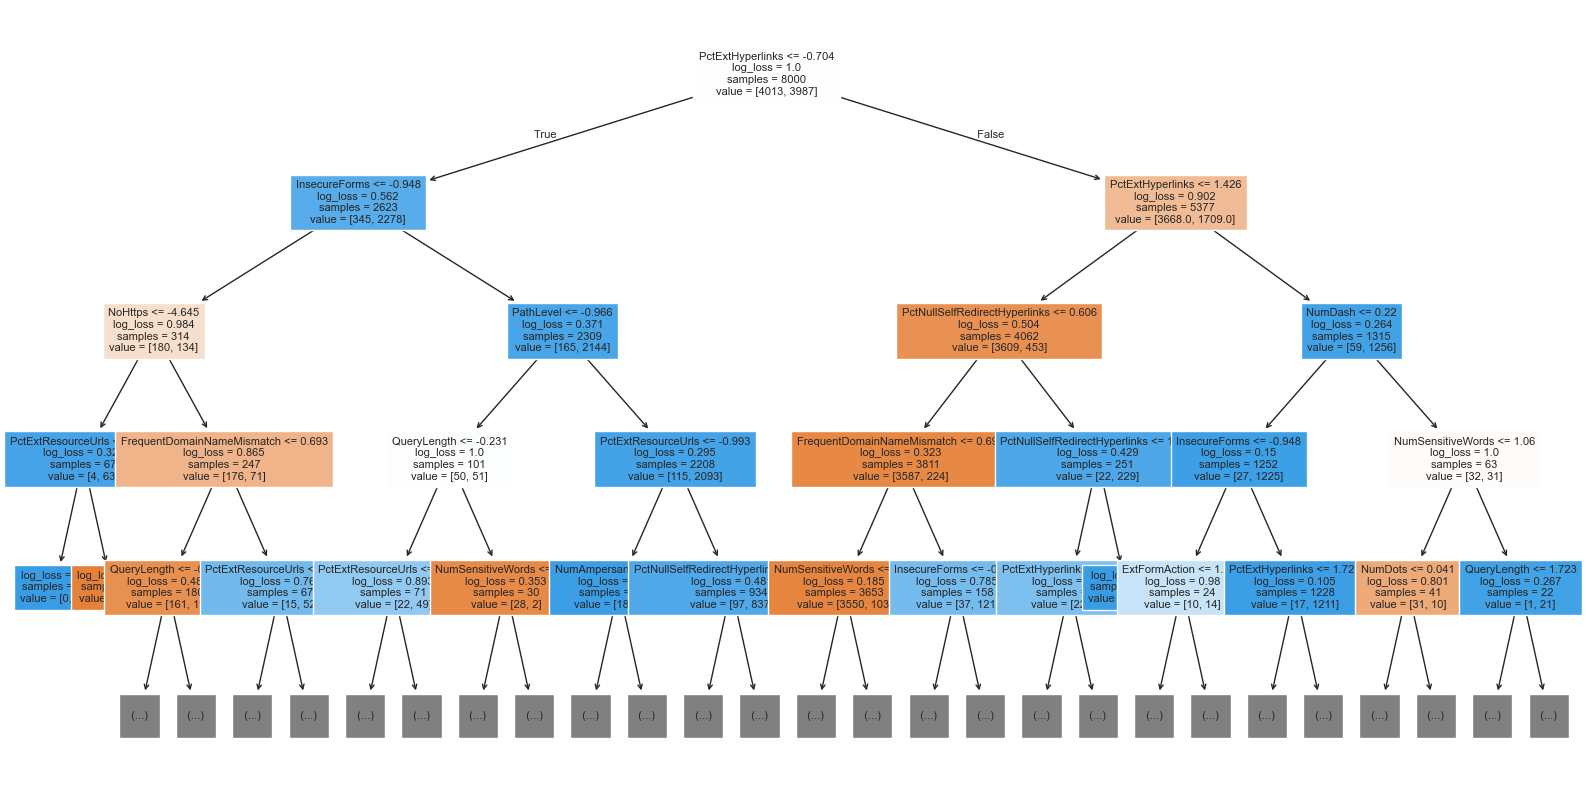

In [31]:
plt.figure(figsize=(20, 10))
plot_tree(gs_dt_clf.best_estimator_, feature_names=feature_names, filled=True, max_depth=4, fontsize=8)
plt.show()

## AdaBoosting

In [32]:
#Let's try an AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)
print(classification_report(y_test, ada_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.96       987
         1.0       0.97      0.96      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



A naive AdaBoostClassifier did pretty well with an f1 of 96%. Let's try hyperparameter tuning to improve that.

{'learning_rate': 1.0, 'n_estimators': 1000}
              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       987
         1.0       0.98      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



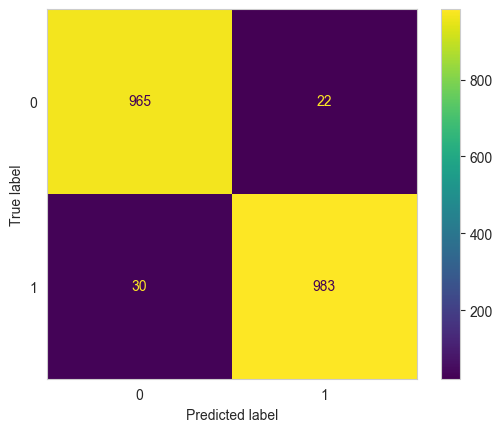

In [33]:
ada_params = [{'n_estimators': [50, 75, 100, 250, 500, 750, 1000],
           'learning_rate':  [0.5, 0.75, 1.0]}]
gs_ada_clf = GridSearchCV(AdaBoostClassifier(), param_grid=ada_params, scoring='f1', cv=5)
gs_ada_clf.fit(X_train, y_train)
print(gs_ada_clf.best_params_)
y_hat = gs_ada_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

This time the hyperparameter tuning moved the needle! That is nice to see. We improved f1 by 1% to 97%. Note that the best number of estimators was the highest (1000). I could have tried more, but I noticed the training process was becoming slow.

## Gradient Boosting ##


In [35]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
print(classification_report(y_test, gb_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       987
         1.0       0.98      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



97% f1 is another good result for the naive GradientBoostingClassifier. Let's try a GridSearch to see if we can do better. Suggestions for hyperparameters to tune and values to consider came from a GeeksforGeeks article (GeeksforGeeks, 2025d)

{'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8}
              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.99      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.99      0.98      2000
weighted avg       0.99      0.98      0.99      2000



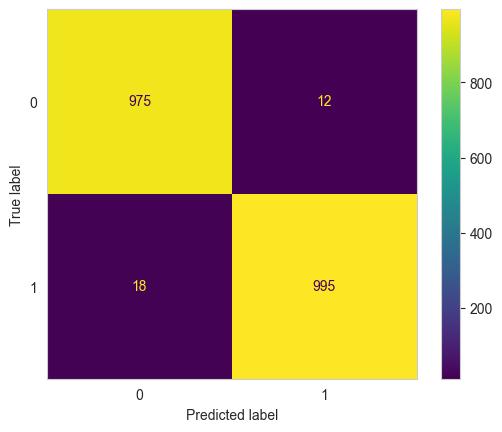

In [36]:
#WARNING: This cell takes approximately 10 minutes to run
gb_params = [{'n_estimators': [100, 500, 1000],
           'learning_rate':  [0.1, 0.25, 0.5],
              'subsample': [0.8, 0.9, 1.0]}]
gs_gb_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=gb_params, scoring='f1', cv=5)
gs_gb_clf.fit(X_train, y_train)
print(gs_gb_clf.best_params_)
y_hat = gs_gb_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We achieved our **best f1 score yet** with 99% for the weighted average! It is also worth noting that our recall for both classes has reached 99%. It is interesting to note that this was achieved with the lowest subsample value. It is possible that better results could be achieved by further lowering the subsample value.

## Random Forest ##

In [37]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
print(classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.98      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



The naive RandomForestClassifier did well with an f1 of 98%. Now we will try to improve that with gridsearch.

{'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 1000}
              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.98      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



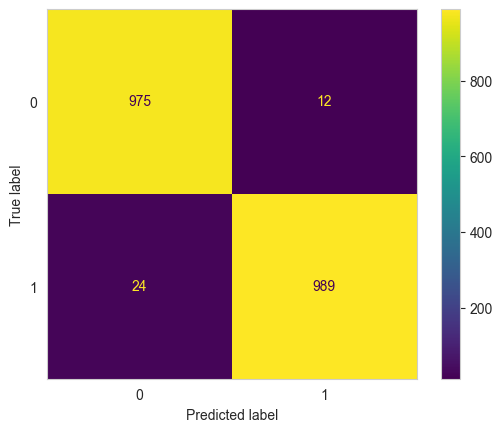

In [38]:
#WARNING; This cell takes almost 10 minutes to run!
rf_params = [{'n_estimators': [1000, 2000],
            'max_depth':  [50, 100],
            'min_samples_leaf': [1, 2, 3, 4, 5] }]
gs_rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_params, scoring='f1', cv=5)
gs_rf_clf.fit(X_train, y_train)
print(gs_rf_clf.best_params_)
y_hat = gs_rf_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

We did not see significant improvement in the f1 score through hyperparameter tuning of the RandomForestClassifier.

## Support Vector Machine ##


In [39]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
print(classification_report(y_test, svm_clf.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.95      0.96      0.95       987
         1.0       0.96      0.95      0.95      1013

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



A naive SVM classifier obtains an f1 score of 95%.
Suggestions for which hyperparameters to tune and what values to consider came from a Geeks for Geeks article on SVM hyperparameter tuning (GeeksforGeeks, 2025a)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97       987
         1.0       0.97      0.96      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



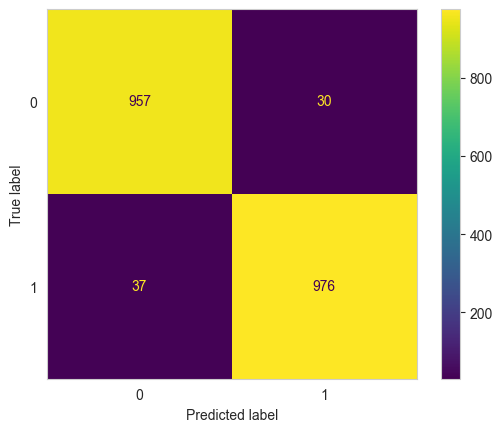

In [40]:
#WARNING - this code takes ~10 minutes to run
svm_params = {'C': [0.1, 1, 10, 100],
			'gamma': [1, 0.1, 0.01, 0.001],
			'kernel': ['linear', 'rbf', 'poly']}
gs_svm_clf = GridSearchCV(SVC(random_state=42), param_grid=svm_params, scoring='f1', cv=5)
gs_svm_clf.fit(X_train, y_train)
print(gs_svm_clf.best_params_)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Hyperparameter tuning gave us a small improvement in our f1 score from 95% to 97%

## Naive Bayes ##
A Naive Bayes classifier is another option offered by scikit-learn. We did not cover this one in class, but a nice thing about scikit learn is that all of the classifiers follow the same usage pattern, so it is fairly strightforward to being using a new classifier. Gaussian Naive Bayes classifier uses the Bayes Theorem. It assumes the features are independent and follow a Gaussian distribution (GeekfoGeeks 2025e). As we see below, this classifier underperforms all the other classifiers so far. If we recall the original histograms showing the distribution of the data, we will recall that many of the features did not have a Gaussian distribution. This explains the poor performance of this classifier. I am not going to attempt hyperparameter tuning because of the apparent poor between this classifier and this data set.

In [42]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print(classification_report(y_test, nb.predict(X_test)))

              precision    recall  f1-score   support

        -1.0       0.76      0.96      0.85       987
         1.0       0.95      0.71      0.81      1013

    accuracy                           0.83      2000
   macro avg       0.86      0.84      0.83      2000
weighted avg       0.86      0.83      0.83      2000



## Multi-Layer Percepteron ##

A Multi-Layer Percepteron (MLP) is a lind of nerual network. While we did not cover this kind of classifier in class, it is relatively easy to use. According to GeeksforGeeks, "MLPs are particularly effective when traditional linear models are insufficient to capture complex patterns in data." (GeeksforGeeks 2005f). I selected the size of the hidden layers by making each approximately half the size of the prior layer. With a neural network, the first layer is the input layer and matches the number of features. The final layer is the output layer and matches the number of classes. The input layer would be 39 afetr we dropped the various feature earlier. So in the first hiddle layer, I set a size of 20, then 10 in the second. Only testing will reveal whether these are good choices.

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=(20, 10),
                    max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
print(classification_report(y_test, mlp.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.97      0.96      0.96       987
         1.0       0.96      0.97      0.96      1013

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



96% f1 is not bad. Let's try some hyperparameter tuning to see if we can do better.

{'hidden_layer_sizes': 20, 'max_iter': 1000}
              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97       987
         1.0       0.97      0.97      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



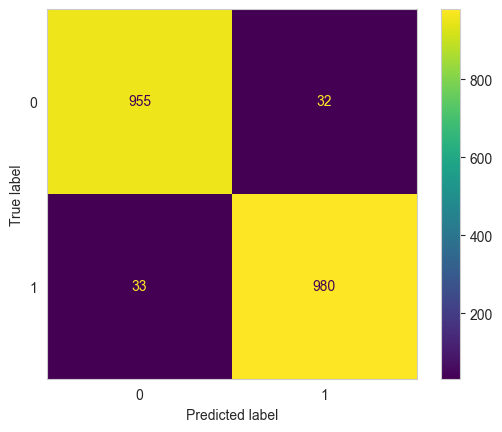

In [48]:
mlp_params = {'hidden_layer_sizes': [(10), (20), (30), (10, 5), (24, 12), (24, 12, 6), (36, 24, 12, 6)],
			'max_iter': [1000, 10000],}
gs_mlp_clf = GridSearchCV(MLPClassifier(random_state=42), param_grid=mlp_params, scoring='f1', cv=5)
gs_mlp_clf.fit(X_train, y_train)
print(gs_mlp_clf.best_params_)
y_hat = gs_mlp_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

## Diverse Voting Ensemble ##


The paper, *PhishGuard: A Multi-Layered Ensemble Model for Optimal Phishing Website Detection* by Ovi, et. al., (Ovi, et. al., 2024) recommends an ensemble of diverse classifiers. We will try this approach using sklearn's VotingClassifier. We will use the optimal parameters discovered previously by grid search for each type of classifier.

We expect that the ensemble of diverse classifiers will perform better than any individual classifier for reasons similar to why ensembles such as AdaBoost and RandomForests perform better than a single DecisionTree.

We will use soft voting in the voting classifier as suggested by a Geeks for Geeks article (GeeksforGeeks, 2025a). This means that rather than each classifier voting a binary answer (1 or 0), they vote a probability that a sample belongs to each class. Soft voting allows the VotingClassifier to take into consideration an underlying model's confidence in the vote (how certain is the model that the sample belongs to one class or the other?).

Note, because of the poor performance of the GaussianNB classifier, I left it out of the ensemble.


              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97       987
         1.0       0.97      0.96      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



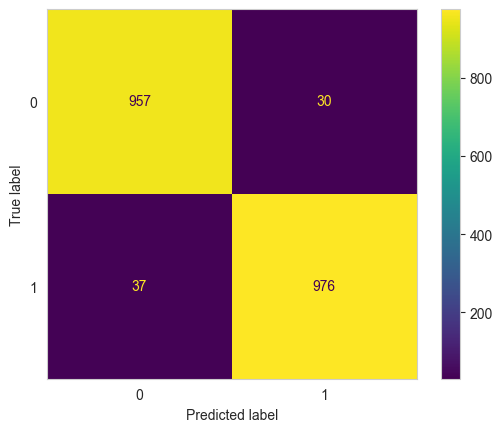

In [49]:
best_classifiers = [
    ('LR', LogisticRegression(max_iter=2500, penalty='l2', solver='liblinear', random_state=42)),
    ('KNN', KNeighborsClassifier(leaf_size=10, n_neighbors=5, weights='distance')),
    ('DT', DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=3, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=20, max_iter=1000, random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='soft')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

The voting classifier **DID NOT** outperform the best classifier included in the voting ensemble. This is initially surprising to me. But perhaps it should be expected because we included several classifiers that achieved only 94% f1 score. Perhaps by removing these low performing classifiers from the voting ensemble, we can do better.

              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97       987
         1.0       0.97      0.96      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



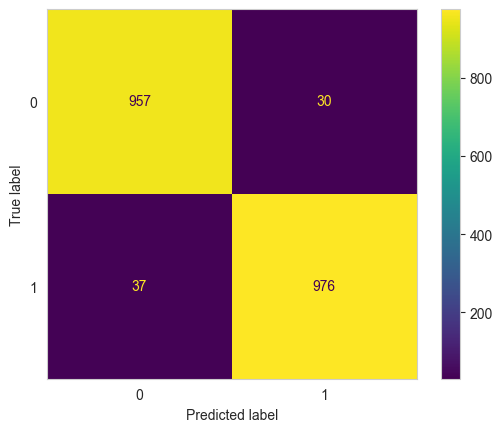

In [50]:
best_classifiers = [
    ('DT', DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=3, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=20, max_iter=1000, random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='soft')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Removing the worst classifiers from the ensemble has a negligable effect. The performance of the ensemble is still slightly worse than an optimized gradient boost classifier or random forest classifier. Next we will try hard voting.

              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97       987
         1.0       0.97      0.96      0.97      1013

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



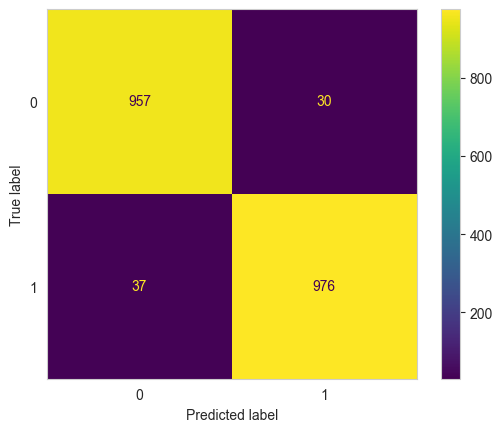

In [51]:
best_classifiers = [
    ('DT', DecisionTreeClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=3, random_state=42)),
    ('ADA', AdaBoostClassifier(learning_rate=1.0, n_estimators=1000, random_state=42)),
    ('GB', GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42)),
    ('RF', RandomForestClassifier(max_depth=50, min_samples_leaf=1, n_estimators=1000, random_state=42)),
    ('SVC', SVC(C=100, gamma=0.01, kernel='rbf', random_state=42)),
    ('MLP', MLPClassifier(hidden_layer_sizes=20, max_iter=1000, random_state=42))
]

voting_clf = VotingClassifier(estimators=best_classifiers, voting='hard')
voting_clf.fit(X_train, y_train)
y_hat = gs_svm_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

Hard voting did not imporve the outcome. We must conclude that for this data set, the very best performing classifiers outperform a voting ensemble that includes less accurate classifiers.

# Results and Analysis #

During the model training and selection phase, I **iterated between training, evaluating, and improving** multiple ML models including Logistic Regression, K Nearest Neighbors, Decision Tree, Adaptive Boosting, Gradient Boosting, Random Forest, Support Vector Machines, Naive Bayes, Multi-layer Perceptron, and Voting Classifier algorithms to determine which performs best with this dataset. I used **hyperparamter tuning** to optimize each model using a GridSearch. I used **Cross Fold Validation** to minimize overfitting. All results were based on test data that the model did not see during training. Several **models not covered in class** were used.

The f1 score for each classifier before and after tuning are shown in the table below.

| Classifier                 | untuned f1 score | tuned f1 score |
|----------------------------|------------------|----------------|
| LogisticRegression         | 0.93             | 0.93           |
| KNeighborsClassifier       | 0.94             | 0.94           |
| DecisionTreeClassifier     | 0.96             | 0.96           |
| AdaBoostClassifier         | 0.96             | 0.97           |
| GradientBoostingClassifier | 0.97             | 0.99           |
| RandomForestClassifier     | 0.98             | 0.98           |
| SVC                        | 0.95             | 0.97           |
| GaussianNB                 | 0.83             | N/A            |
| MLPClassifier              | 0.96             | 0.97           |
| VotingClassifier           | N/A              | 0.97           |


The best f1 score and the fewest misclassified examples were achieved with a **GradientBoostingClassifier** after conducting a grid search for the optimal hyperparameters. That optimized classifier and it's results are shown below. I achieved a **99% f1 score, accuracy, and recall for all classes**. Only 30 of 2000 test examples were misclassified.

This was achieved after **iterating** over many model types, and for each model type, **iterating** over many hyperparameters.

The **metrics** used to evalue the model include: **f1-score, accuracy, precision, and recall.** For all of these metrics, this model performed the best. Additionally, the **Area Under Curve** metric is shown below.

              precision    recall  f1-score   support

        -1.0       0.98      0.99      0.98       987
         1.0       0.99      0.98      0.99      1013

    accuracy                           0.98      2000
   macro avg       0.98      0.99      0.98      2000
weighted avg       0.99      0.98      0.99      2000



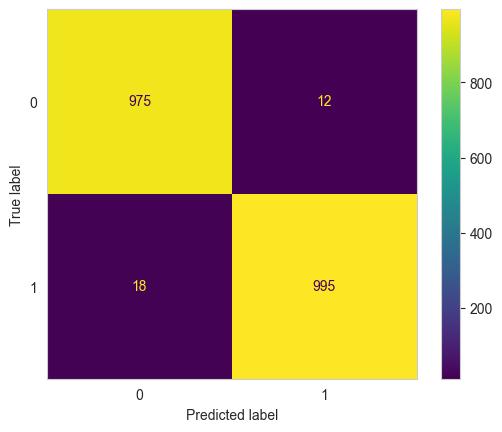

In [52]:
best_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42)
best_clf.fit(X_train, y_train)
y_hat = best_clf.predict(X_test)
print(classification_report(y_test, y_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_hat)).plot()
disp.ax_.grid(False)
plt.show()

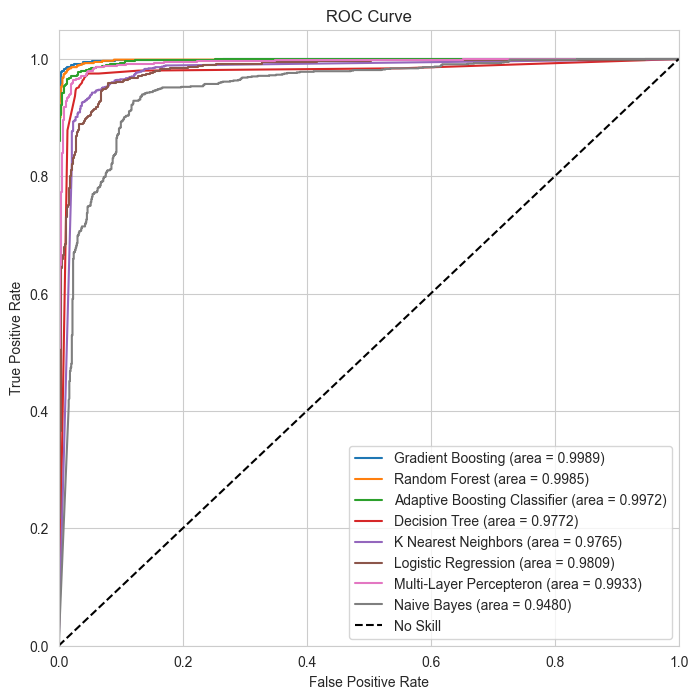

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, gs_lr_clf.predict_proba(X_test)[:, 1])
lr_roc_auc = auc(lr_fpr, lr_tpr)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, gs_knn_clf.predict_proba(X_test)[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, gs_dt_clf.predict_proba(X_test)[:, 1])
dt_roc_auc = auc(dt_fpr, dt_tpr)
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, gs_ada_clf.predict_proba(X_test)[:, 1])
ada_roc_auc = auc(ada_fpr, ada_tpr)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, gs_rf_clf.predict_proba(X_test)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
nb_roc_auc = auc(nb_fpr, nb_tpr)
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, gs_mlp_clf.predict_proba(X_test)[:, 1])
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.4f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.4f)' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, label='Adaptive Boosting Classifier (area = %0.4f)' % ada_roc_auc)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.4f)' % dt_roc_auc)
plt.plot(knn_fpr, knn_tpr, label='K Nearest Neighbors (area = %0.4f)' % knn_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (area = %0.4f)' % lr_roc_auc)
plt.plot(mlp_fpr, mlp_tpr, label='Multi-Layer Percepteron (area = %0.4f)' % mlp_roc_auc)
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (area = %0.4f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

As a final confirmation of our results, we have compared the Receiver Operating Characteristics (ROC) curves for the various tuned models. We can see that Gradient Boosting remains the best performer with Random Forest coming in a very close second place. We can also see that the GassianNB classifier performed notably poorly compared to the other models.

# Discussion and Conclusion #
## Learnings and Takeaways ##
Examination of the initial data set showed that no features are strongly correlated to the label.  There are several features that more correlated than others with the CLASS_LABEL. These include FrequentDomainNameMismatch (0.464), InsecureForms (0.31), NumDots (0.294), NumDash (-0.372), and SubmitInfoToEmail (-0.358). But the vast majority of features have almost no correlation with the class label. The lack of obvious correlation makes this a very interesting problem for machine learning. It is not reasonable to expect a human to discern patterns in this data that can be reliably used to predict the class label.

While the best model for this task turned out to be a GradientBoostingClassifier, several other models also performed well. A key takeaway is that it is worthwhile to test the performance of various models on your data to find the best performing model.

We can conclude a few things from these results. First is that the default hyperparameters for the models tested were well-suited to this dataset. Prior to hyperparameter tuning, f1 scores ranged from 0.93-0.98. After hyperparameter tuning, f1 scores ranged from 0.93 to 0.99. Only a few models saw their f1 score increase enough to change the results on a classification report (which is rounded to two significant digits). These models were AdaBoostClassifier, GradientBoostingClassifier, SVC, and Multi-Layer Percepteron. An important takeway is that though default parameters seem to be well selected, hyperparameter tuning is a worthwhile effort if you want to get the best performance out of your model.

## Things that Didn't Work as Expected ##

The **VotingClassifier** did not produce results better than the best individual classifier. This may be because ensembles tend to work best when averaging many weak learners. All of these models were strong learners and we used only a small number of models. It makes sense intuitively that the average of the results of a small number of models will be less than the results of the best model.  Additionally, many of these models were, themselves, ensembles containing up to 1000 classifiers each. This may have reduced the impact of adding a few more through a VotingClassifier.

The **GaussianNB model performed notably poorly** compared to other models. This is almost certainly because many of the features did not have a normal distribution. Rather, they had more instances towards the low end of their range and longer tails towards the large end of the range. Distributions like this are poorly-suited for a Naive Bayes classifier.

## Future Improvements ##

The **best classifier** found was **GradientBoostingClassifier** with a learning_rate=0.1, n_estimators=500, and subsample=0.8. with this classifier, we achieved a **99% f1 score, accuracy, and recall for all classes**. Only 30 of 2000 test examples were misclassified. It is worth noting that learning rate of 0.1 was the smallest value provided in the grid search parameters. Similarly, a subsample of 0.8 was the smallest subsample provided in the parameters. **Further investigation is warranted** into whether decreasing the learning rate below 0.1 and/or reducing the subsample below 0.8 can provide an increased f1 score.


# Citations #


GeeksforGeeks. (2025a, July 12). Voting classifier using Sklearn - ml. https://www.geeksforgeeks.org/machine-learning/ml-voting-classifier-using-sklearn/

GeeksforGeeks. (2025b, July 23). How to optimize logistic regression performance. https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/

GeeksforGeeks. (2025c, September 2). SVM hyperparameter tuning using GRIDSEARCHCV - ml. https://www.geeksforgeeks.org/machine-learning/svm-hyperparameter-tuning-using-gridsearchcv-ml/

GeeksforGeeks. (2025d, September 5). How to tune hyperparameters in Gradient Boosting Algorithm. https://www.geeksforgeeks.org/machine-learning/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/

GeeksforGeeks. (2025e, June 23). Gaussian Naive Bayes using Sklearn. https://www.geeksforgeeks.org/machine-learning/gaussian-naive-bayes-using-sklearn/

GeeksforGeeks. (2025f, July 23). Classification Using Sklearn Multi-layer Perceptron. https://www.geeksforgeeks.org/machine-learning/classification-using-sklearn-multi-layer-perceptron/

Kumar, R. (2024, September 21). GRIDSEARCHCV simplified: Hyperparameter tuning for newbies. Medium. https://medium.com/@hereisranjan/gridsearchcv-simplified-hyperparameter-tuning-for-newbies-36a50c267d31

Ovi, M. S. I., Rahman, Md. H., & Hossain, M. A. (2024, September 29). PhishGuard: A multi-layered ensemble model for optimal phishing website detection. arXiv.org. https://arxiv.org/abs/2409.19825

Ovi, Sultanul. (2025). *Phishing Website Detection Datasets.* Kaggle. https://www.kaggle.com/datasets/mdsultanulislamovi/phishing-website-detection-datasets/data?select=dataset6.csv

Yarbrough, B. C. (n.d.). Federal Bureau of Investigation Internet Crime Report 2024. Internet Crime Complaint Center. https://www.ic3.gov/AnnualReport/Reports/2024_IC3Report.pdf



